In [5]:
import os
import json
import PIL.Image
import random
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms

from src.models.Models import DeeperCNN, SimpleCNN
from src.attacks.attacks import FastGradientSign, ProjectedGradientDescent
from src.training.Trainer import Trainer

In [6]:
def load_model(num_classes = 20, model_path = None, to_cuda = True, deep_net = False):
    if not model_path:
        if deep_net:
            model = DeeperCNN()
        else:
            model = SimpleCNN()
        loaded_state_dict = False
    
    else:
        print("Loaded", model_path)
        if deep_net:
            model = DeeperCNN()
        else:
            model = SimpleCNN()
            
        loaded_model = torch.load(model_path)
        model.load_state_dict(loaded_model['model_state_dict'])
        loaded_state_dict = True
        
    if to_cuda:
        model = model.to('cuda')
        
    return model, loaded_state_dict



In [7]:
batch_size = 128
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
transform = transforms.Compose(
    [transforms.ToTensor()]
)
mnist_train = torchvision.datasets.MNIST(root = 'Data/', train = True, download= True, transform=transform)
mnist_test = torchvision.datasets.MNIST(root = 'Data/', train = False, download= True, transform=transform)
#train_set, val_set = torch.utils.data.random_split(mnist_train, [55000, 5000])
#test_set = mnist_test


train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False)
#test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

cnn_model, loaded_state_dict = load_model(model_path = "models/simple_cnn.pt")

dataloaders = {
    'train': train_loader,
    'val': val_loader
}

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(cnn_model.parameters(), lr = 1e-3, weight_decay = 0.01)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[4,7], gamma=0.1)

training_params = {
    'dataloaders': dataloaders,
    'optimizer': optimizer,
    'scheduler': scheduler
}

classes = torch.arange(10).tolist()
classes = [str(i) for i in classes]

Loaded models/simple_cnn.pt


In [9]:
pgd = ProjectedGradientDescent(cnn_model, loss_fn, iterations = 5, alpha = 0.15, epsilon = 0.15, return_logits=False)
trainer = Trainer(cnn_model, loss_fn, classes, training_params, DEVICE, num_epochs = 10, model_name = 'simple_cnn', save_model = True, model_dir = 'models', mnist = True, adversarial_training = True, adversarial_attack = pgd)

In [11]:
trainer.run_validation_loop_only()

Val Loop:
Batch: 0 of 79. Loss: 2.556981086730957. Mean so far: 2.556981086730957. Mean of 100: 2.556981086730957
Validation loss: 2.443134514591362. Val measure: 0.2216
Validation loop took 2.95062255859375
Current Epoch: 0
Eval Model:  simple_cnn . Acc:  0.2216 . Avg loss: 2.443134514591362
Accuracy of 0                                                                     :  0.5163265306122449
Accuracy of 1                                                                     :  0.13392070484581498
Accuracy of 2                                                                     :  0.2819767441860465
Accuracy of 3                                                                     :  0.18415841584158416
Accuracy of 4                                                                     :  0.18533604887983707
Accuracy of 5                                                                     :  0.1132286995515695
Accuracy of 6                                                                  

In [33]:
trainer = Trainer(cnn_model, loss_fn, classes, training_params, DEVICE, num_epochs = 10, model_name = 'simple_cnn', save_model = True, model_dir = 'models', mnist = True)

In [34]:
trainer.train()

Current Epoch: 0
Train Loop:
Batch: 0 of 469. Loss: 2.304417848587036. Mean so far: 2.304417848587036. Mean of 100: 2.304417848587036
Batch: 100 of 469. Loss: 0.3558048605918884. Mean so far: 0.7112867079748966. Mean of 100: 0.6953553965687752
Batch: 200 of 469. Loss: 0.3298702836036682. Mean so far: 0.5243917901569338. Mean of 100: 0.3356279231607914
Batch: 300 of 469. Loss: 0.14256727695465088. Mean so far: 0.44423345558073035. Mean of 100: 0.2831152030825615
Batch: 400 of 469. Loss: 0.18987730145454407. Mean so far: 0.3956891730836502. Mean of 100: 0.24957088276743888
Train loss: 0.3713954360182606. Train measure: 0.88755
Train loop took 14.126042127609253
Val Loop:
Batch: 0 of 79. Loss: 0.09309902042150497. Mean so far: 0.09309902042150497. Mean of 100: 0.09309902042150497
Validation loss: 0.1316426994066827. Val measure: 0.96
Validation loop took 1.328545331954956
Current Epoch: 0
Eval  Model:  simple_cnn . Acc:  0.96 . Avg loss: 0.1316426994066827
Train Model:  simple_cnn . Acc 0

In [6]:
transform = transforms.Compose(
    [transforms.ToTensor()]
)
mnist_train = torchvision.datasets.MNIST(root = 'Data/', train = True, download= True, transform=transform)
mnist_test = torchvision.datasets.MNIST(root = 'Data/', train = False, download= True, transform=transform)
#train_set, val_set = torch.utils.data.random_split(mnist_train, [55000, 5000])
#test_set = mnist_test


train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False)
#test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

deeper_net, loaded_state_dict = load_model(deep_net = True)

dataloaders = {
    'train': train_loader,
    'val': val_loader
}

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(deeper_net.parameters(), lr = 1e-4, weight_decay = 0.01)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[4, 7], gamma=0.1)

training_params = {
    'dataloaders': dataloaders,
    'optimizer': optimizer,
    'scheduler': scheduler
}

classes = torch.arange(10).tolist()
classes = [str(i) for i in classes]

In [17]:
trainer = Trainer(deeper_net, loss_fn, classes, training_params, DEVICE, num_epochs = 10, model_name = 'deeper_cnn', save_model = True, model_dir = 'models', mnist = True)

In [18]:
trainer.train()

Current Epoch: 0
Train Loop:
Batch: 0 of 469. Loss: 2.30448579788208. Mean so far: 2.30448579788208. Mean of 100: 2.30448579788208
Batch: 100 of 469. Loss: 2.3010287284851074. Mean so far: 2.3004788148521196. Mean of 100: 2.30043874502182
Batch: 200 of 469. Loss: 0.8001955151557922. Mean so far: 2.0605388882741407. Mean of 100: 1.8181995624303817
Batch: 300 of 469. Loss: 0.45611026883125305. Mean so far: 1.5829675730280701. Mean of 100: 0.6230492293834686
Batch: 400 of 469. Loss: 0.38384971022605896. Mean so far: 1.29963718536786. Mean of 100: 0.44681271851062776
Train loss: 1.1650356510872526. Train measure: 0.6016333333333334
Train loop took 10.969702959060669
Val Loop:
Batch: 0 of 79. Loss: 0.2102145254611969. Mean so far: 0.2102145254611969. Mean of 100: 0.2102145254611969
Validation loss: 0.3167757089662401. Val measure: 0.9049
Validation loop took 1.2007973194122314
Current Epoch: 0
Eval  Model:  deeper_cnn . Acc:  0.9049 . Avg loss: 0.3167757089662401
Train Model:  deeper_cnn . 

# Adversarial fine-tuning

## Small CNN

In [51]:
transform = transforms.Compose(
    [transforms.ToTensor()]
)
mnist_train = torchvision.datasets.MNIST(root = 'Data/', train = True, download= True, transform=transform)
mnist_test = torchvision.datasets.MNIST(root = 'Data/', train = False, download= True, transform=transform)
#train_set, val_set = torch.utils.data.random_split(mnist_train, [55000, 5000])
#test_set = mnist_test


train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False)
#test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

cnn_model, loaded_state_dict = load_model(model_path = 'models/simple_cnn.pt')

dataloaders = {
    'train': train_loader,
    'val': val_loader
}

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(cnn_model.parameters(), lr = 1e-4, weight_decay = 0.01)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[4,7], gamma=0.1)

training_params = {
    'dataloaders': dataloaders,
    'optimizer': optimizer,
    'scheduler': scheduler
}

classes = torch.arange(10).tolist()
classes = [str(i) for i in classes]

Loaded models/simple_cnn.pt


In [55]:
pgd = ProjectedGradientDescent(cnn_model, loss_fn, iterations = 5, alpha = 0.15, epsilon = 0.15, return_logits=False)

In [56]:
trainer = Trainer(cnn_model, loss_fn, classes, training_params, DEVICE, num_epochs = 10, model_name = 'simple_cnn_adv_trained', save_model = True, model_dir = 'models', mnist = True, adversarial_training = True, adversarial_attack = pgd)

In [58]:
trainer.train()

Current Epoch: 0
Train Loop:
Batch: 0 of 469. Loss: 2.7565958499908447. Mean so far: 2.7565958499908447. Mean of 100: 2.7565958499908447
Batch: 100 of 469. Loss: 0.8909196853637695. Mean so far: 1.2908252436335723. Mean of 100: 1.2761675375699997
Batch: 200 of 469. Loss: 0.907312273979187. Mean so far: 1.1174191325458127. Mean of 100: 0.9422789603471756
Batch: 300 of 469. Loss: 0.7757707238197327. Mean so far: 1.018414734803957. Mean of 100: 0.8194158953428269
Batch: 400 of 469. Loss: 0.9834883213043213. Mean so far: 0.9533379882053842. Mean of 100: 0.7574569809436799
Train loss: 0.9196365550636991. Train measure: 0.6769833333333334
Train loop took 46.071255683898926
Val Loop:
Batch: 0 of 79. Loss: 0.6759085059165955. Mean so far: 0.6759085059165955. Mean of 100: 0.6759085059165955
Validation loss: 0.6624380119993717. Val measure: 0.7697
Validation loop took 6.788945913314819
Current Epoch: 0
Eval  Model:  simple_cnn_adv_trained . Acc:  0.7697 . Avg loss: 0.6624380119993717
Train Model

### Normal samples

In [103]:
trainer = Trainer(cnn_model, loss_fn, classes, training_params, DEVICE, num_epochs = 10, model_name = 'simple_cnn_adv_trained', save_model = True, model_dir = 'models', mnist = True)

In [104]:
trainer.run_validation_loop_only()

Val Loop:
Batch: 0 of 79. Loss: 0.05993945524096489. Mean so far: 0.05993945524096489. Mean of 100: 0.05993945524096489
Validation loss: 0.080809648867838. Val measure: 0.9817
Validation loop took 1.2148871421813965
Current Epoch: 0
Eval Model:  simple_cnn_adv_trained . Acc:  0.9817 . Avg loss: 0.080809648867838
Accuracy of 0                                                                     :  0.9948979591836735
Accuracy of 1                                                                     :  0.9947136563876652
Accuracy of 2                                                                     :  0.9806201550387597
Accuracy of 3                                                                     :  0.9841584158415841
Accuracy of 4                                                                     :  0.9755600814663951
Accuracy of 5                                                                     :  0.9865470852017937
Accuracy of 6                                                 

## Deeper CNN

In [85]:
transform = transforms.Compose(
    [transforms.ToTensor()]
)
mnist_train = torchvision.datasets.MNIST(root = 'Data/', train = True, download= True, transform=transform)
mnist_test = torchvision.datasets.MNIST(root = 'Data/', train = False, download= True, transform=transform)
#train_set, val_set = torch.utils.data.random_split(mnist_train, [55000, 5000])
#test_set = mnist_test


train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False)
#test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

deeper_net, loaded_state_dict = load_model(model_path = 'models/deeper_cnn.pt',deep_net = True)

dataloaders = {
    'train': train_loader,
    'val': val_loader
}

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(deeper_net.parameters(), lr = 1e-4, weight_decay = 0.01)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[4, 7], gamma=0.1)

training_params = {
    'dataloaders': dataloaders,
    'optimizer': optimizer,
    'scheduler': scheduler
}

classes = torch.arange(10).tolist()
classes = [str(i) for i in classes]

Loaded models/deeper_cnn.pt


In [92]:
pgd = ProjectedGradientDescent(deeper_net, loss_fn, iterations = 5, alpha = 0.15, epsilon = 0.15, return_logits=False)

In [93]:
trainer = Trainer(deeper_net, loss_fn, classes, training_params, DEVICE, num_epochs = 10, model_name = 'deeper_cnn_adv_trained', save_model = True, model_dir = 'models', mnist = True, adversarial_training = True, adversarial_attack = pgd)

In [94]:
trainer.run_validation_loop_only()

Val Loop:
Batch: 0 of 79. Loss: 10.604079246520996. Mean so far: 10.604079246520996. Mean of 100: 10.604079246520996
Validation loss: 10.168242490744289. Val measure: 0.0067
Validation loop took 4.5562591552734375
Current Epoch: 0
Eval Model:  deeper_cnn_adv_trained . Acc:  0.0067 . Avg loss: 10.168242490744289
Accuracy of 0                                                                     :  0.03163265306122449
Accuracy of 1                                                                     :  0.0
Accuracy of 2                                                                     :  0.02616279069767442
Accuracy of 3                                                                     :  0.006930693069306931
Accuracy of 4                                                                     :  0.0
Accuracy of 5                                                                     :  0.002242152466367713
Accuracy of 6                                                                     :  0.

In [95]:
trainer.train()

Current Epoch: 0
Train Loop:
Batch: 0 of 469. Loss: 9.58452033996582. Mean so far: 9.58452033996582. Mean of 100: 9.58452033996582
Batch: 100 of 469. Loss: 1.9944404363632202. Mean so far: 3.06745187126764. Mean of 100: 3.002281186580658
Batch: 200 of 469. Loss: 1.7279146909713745. Mean so far: 2.4369693988591283. Mean of 100: 1.800182101726532
Batch: 300 of 469. Loss: 1.2573164701461792. Mean so far: 2.115862563598988. Mean of 100: 1.4704378247261047
Batch: 400 of 469. Loss: 1.0235486030578613. Mean so far: 1.8816937502482882. Mean of 100: 1.176845622062683
Train loss: 1.7607473345961906. Train measure: 0.43106666666666665
Train loop took 31.434920072555542
Val Loop:
Batch: 0 of 79. Loss: 0.8882824778556824. Mean so far: 0.8882824778556824. Mean of 100: 0.8882824778556824
Validation loss: 0.9491151375106618. Val measure: 0.6386
Validation loop took 4.7257726192474365
Current Epoch: 0
Eval  Model:  deeper_cnn_adv_trained . Acc:  0.6386 . Avg loss: 0.9491151375106618
Train Model:  deepe

### Normal samples

In [105]:
trainer = Trainer(deeper_net, loss_fn, classes, training_params, DEVICE, num_epochs = 10, model_name = 'simple_cnn_adv_trained', save_model = True, model_dir = 'models', mnist = True)
trainer.run_validation_loop_only()

Val Loop:
Batch: 0 of 79. Loss: 0.07500673830509186. Mean so far: 0.07500673830509186. Mean of 100: 0.07500673830509186
Validation loss: 0.11409420194693759. Val measure: 0.9717
Validation loop took 1.431471586227417
Current Epoch: 0
Eval Model:  simple_cnn_adv_trained . Acc:  0.9717 . Avg loss: 0.11409420194693759
Accuracy of 0                                                                     :  0.9908163265306122
Accuracy of 1                                                                     :  0.9894273127753304
Accuracy of 2                                                                     :  0.9777131782945736
Accuracy of 3                                                                     :  0.9712871287128713
Accuracy of 4                                                                     :  0.9501018329938901
Accuracy of 5                                                                     :  0.9708520179372198
Accuracy of 6                                              

# Interpretatbility

In [115]:
import matplotlib.pyplot as plt

In [116]:
tti = transforms.ToPILImage()

In [143]:
pgd = ProjectedGradientDescent(cnn_model, loss_fn, iterations = 5, alpha = 0.15, epsilon = 0.15, return_logits=False)

In [144]:
for samp in val_loader:
    perturbed_image = pgd(samp[0], samp[1], random_start = True, compute_original_prediction = False, compute_new_preds = False)
    break

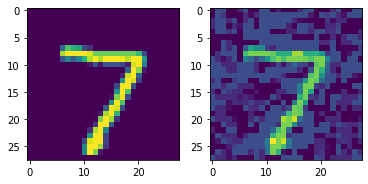

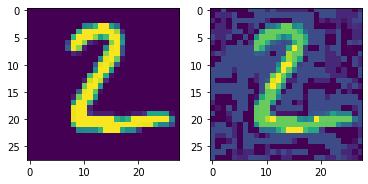

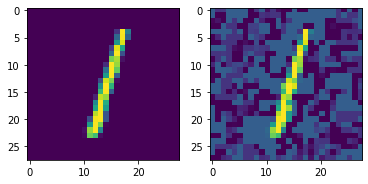

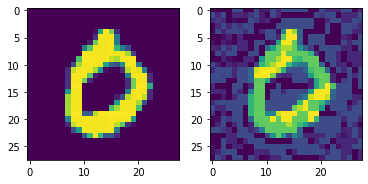

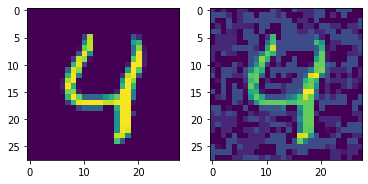

In [147]:
for i in range(5):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(samp[0][i].detach().squeeze())
    ax2.imshow(perturbed_image[i].cpu().squeeze())
    plt.show()